In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 303, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 303 (delta 80), reused 66 (delta 55), pack-reused 163
Receiving objects: 100% (303/303), 54.18 MiB | 21.96 MiB/s, done.
Resolving deltas: 100% (137/137), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=24553 sha256=932033b97a724d2133a17334ff172bb72a08b557b12541ef94ef9d038a7642d0
  Stored in directory: /tmp/pip-ephem-wheel-cache-olnwnfnv/wheels/55/59/29/0fb1c6356521577

In [2]:
from dul_2021.utils.hw9_utils import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from torch.distributions.beta import Beta

import copy

from scipy.stats import norm
from scipy.optimize import bisect
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1: EBM on MNIST

Here we will implement EBM on MNIST data. 

* **Architecture.** You may experiment with different hyperparameters and architecture designs, but 
the following designs for the EBM architecture may be useful.

```
    Conv2d(1, 16, 5, 2, 4), 
    Swish(),
    Conv2d(16, 32, 3, 2, 1),
    Swish(), 
    Conv2d(32, 64, 3, 2, 1), 
    Swish(), 
    Conv2d(64, 64, 3, 2, 1), 
    Swish(),
    Flatten(),
    Linear(256, 64), 
    Swish(),
    Linear(64, 1)
```


Where `swish(x) = σ(x)x`. You **should** use activation with non-sparse gradients for better MCMC convergence.

* **Buffer.** To use the contrastive divergence objective, we need to generate samples during training. Because of high dimension of image space we need a lot of iterations in MCMC to obtain reasonable samples. We can reduce sampling cost with buffer trick. The idea of this trick it to re-use previous samples as starting points for MCMC (since distribuionts are close). In our implementation, we initialize 95% of starting points with previous samples and 5% with random noise from -1 to 1. 

* **MCMC.** During MCMC procedure you only need gradients wrt input. You can find it helpful to disable gradients of your model during MCMC. Since all images are in [-1, 1] you should clamp all resulting points during MCMC step. We also clamp gradients to [-0.03, 0.03].
    ```
    for p in model.parameters():
        p.requires_grad = False
    ```

* **Regularizations.**

 You should add small noise to real data otherwise ebm will focus on black areas of real images won't train.

 Add l2 regularaztion to ebm outputs on real and fake data. Otherwise, the output values will fluctuate in a very large range (because energy is invariant to scalar shift).

* **Hyperparameters**
    * Max buffer size - 8192
    * MCMC step size - 10
    * MCMC # step - 60
    * MCMC noise - N(0, 0.005)
    * Noise to data - N(0, 0.005)
    * l2 reg weight - 0.1
    * batch_size - 128
    * use Adam with lr=1e-3 and betas=(0, 0.999)
    * you can exponential scheduler
    * 20 epochs should be enough (~1 hour on gpu)



**You will provide the following deliverables**


1.   Over the course of training, record the regularization and contrastive losses per batch.
2. 100 samples from your trained EBM

In [4]:
class Buffer():
    def __init__(self, max_size=8192):
        self.max_size = max_size
        self.buffer = torch.empty(0, 1, 28, 28).to(device)

    def buffer_size(self,):
        return self.buffer.shape[0]

    def free_space(self,):
        return self.max_size - self.buffer.shape[0]

    def sample(self, n):
        ids = torch.randint(0, self.buffer_size(), (n,))
        return self.buffer[ids]

    def update(self, x):
        if self.free_space() == 0:
            self.buffer = self.buffer[-(self.max_size - x.shape[0]):]
            self.buffer = torch.cat([self.buffer, x], dim=0)
        elif x.shape[0] < self.free_space():
            self.buffer = torch.cat([self.buffer, x], dim=0)
        else:
            to_free = x.shape[0] - self.free_space()
            self.buffer = self.buffer[-(self.buffer_size() - to_free):]
            self.buffer = torch.cat([self.buffer, x], dim=0)

In [29]:
from torch.autograd import Variable

class Swish(nn.Module):
    def __init__(self,):
        super().__init__()
    
    def forward(self, x):
        return torch.sigmoid(x) * x

class EBM(nn.Module):
    def __init__(self, max_buffer_size=8192, mcmc_step_size=10, 
                 mcmc_steps=60, data_noise=0.005, mcmc_noise=0.005,
                 l2_reg_weight=0.1):
        super().__init__()

        self.buffer = Buffer(max_buffer_size)
        self.mcmc_step_size = mcmc_step_size
        self.mcmc_steps = mcmc_steps
        self.data_noise = data_noise
        self.mcmc_noise = mcmc_noise
        self.l2_reg_weight = l2_reg_weight

        self.E = nn.Sequential(
            nn.Conv2d(1, 16, 5, 2, 4), 
            Swish(),
            nn.Conv2d(16, 32, 3, 2, 1),
            Swish(), 
            nn.Conv2d(32, 64, 3, 2, 1), 
            Swish(), 
            nn.Conv2d(64, 64, 3, 2, 1), 
            Swish(),
            nn.Flatten(),
            nn.Linear(256, 64), 
            Swish(),
            nn.Linear(64, 1),
            )
        
    
    def loss(self, real, fake, noise=0):
        noise = torch.randn(real.shape) * noise # ** 0.5
        noise = noise.to(device)
        real = real + noise
        e_real = self.E(real)
        e_fake = self.E(fake)
        loss = -(e_fake.mean() - e_real.mean())
        l2_reg = (e_fake ** 2 + e_real ** 2).mean()
        return loss, l2_reg


    def fit(self, train_data, lr=1e-3, num_epochs=20, bs=128, betas=(0, 0.999)):
        trainloader = data.DataLoader(train_data,
                                      batch_size=bs, 
                                      shuffle=True)

        optim = opt.Adam(self.E.parameters(), lr=lr, betas=betas)
        sch = opt.lr_scheduler.ExponentialLR(optim, gamma=0.1)
        train_loss_C = []
        train_loss_R = []

        
        for epoch in tqdm(range(num_epochs)):
            t_losses_R = []
            t_losses_C = []
            for i, r_batch in enumerate(tqdm(trainloader)):
                r_batch = r_batch.float().to(device)
                bs = r_batch.shape[0]
                f_batch = self.sample(n_samples=bs)
                c_loss, r_loss = self.loss(r_batch, f_batch, self.data_noise)
                loss = (c_loss + self.l2_reg_weight * r_loss).mean()
                optim.zero_grad()
                loss.backward()
                optim.step()

                train_loss_C.append((c_loss).mean().item())
                t_losses_C.append((c_loss).mean().item())
                train_loss_R.append((r_loss).mean().item())
                t_losses_R.append((r_loss).mean().item())


            print(f'Epoch {epoch + 1}: contr_loss= {np.mean(t_losses_C):.5f},  reg_loss= {np.mean(t_losses_R):.5f}')
            sch.step()

        return np.array(train_loss_C), np.array(train_loss_R)


    def energy_freeze(self,):
        for p in self.E.parameters():
            p.requires_grad = False

    def energy_unfreeze(self,):
        for p in self.E.parameters():
            p.requires_grad = True

    def sample(self, n_samples=100):
        self.energy_freeze()
        self.E.eval()

        if self.buffer.buffer_size() == 0:
            x = (torch.rand(n_samples, 1, 28, 28) - 0.5) * 2
            x = x.to(device)
        else:
            buffer_start_num = int(0.95 * n_samples)
            random_start_num = n_samples - buffer_start_num
            x_buf = self.buffer.sample(buffer_start_num)
            x_rand = (torch.rand(random_start_num, 1, 28, 28) - 0.5) * 2 
            x_rand = x_rand.to(device)
            x = torch.cat([x_buf, x_rand], dim=0)
        x = Variable(x)
        x.requires_grad = True
        
        for _ in range(self.mcmc_steps):
            e = self.E(x)
            score_fun = -torch.autograd.grad(outputs=e.sum(), inputs=x)[0] 
            score_fun = torch.clamp(score_fun, min=-0.03, max=0.03)
            z = torch.randn(x.shape) * self.mcmc_noise # ** 0.5
            z = z.to(device)
            x = x + self.mcmc_step_size * score_fun + (2 * self.mcmc_step_size) ** 0.5 * z
            x = torch.clamp(x, min=-1, max=1)

        self.buffer.update(x)
        self.energy_unfreeze()
        self.E.train()
        return x

In [33]:
def q1(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array full of contrastive losses on each iteration
    - a (# of training iterations, ) numpy array full of regularization losses on each iteration
    - a (100, 28, 28, 1) numpy array of 100 samples from ebm model
    """

    train_data, _ = zip(*train_data)
    train_data = torch.stack(train_data, dim=0)
    model = EBM()
    model.to(device)
    contr_loss, reg_loss = model.fit(train_data, num_epochs=20)
    samples = model.sample(100).detach().cpu().numpy()

    return contr_loss, reg_loss, samples

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: contr_loss= -0.01217,  reg_loss= 0.05445


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: contr_loss= -0.00102,  reg_loss= 0.00250


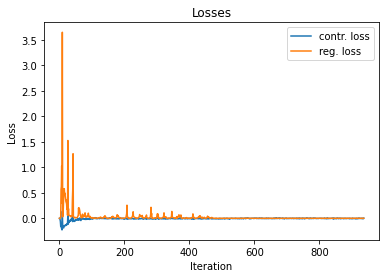

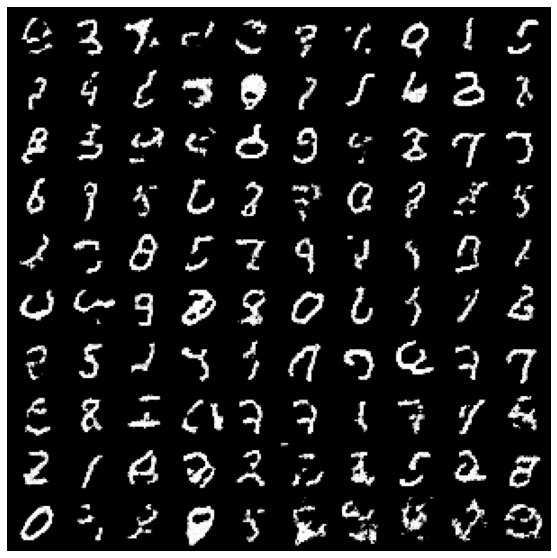

In [24]:
q1_results(q1) # 2 ep

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: contr_loss= -0.00996,  reg_loss= 0.04452


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: contr_loss= -0.00020,  reg_loss= 0.00226


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: contr_loss= -0.00039,  reg_loss= 0.00205


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: contr_loss= -0.00045,  reg_loss= 0.00207


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: contr_loss= 0.00060,  reg_loss= 0.00212


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6: contr_loss= 0.00010,  reg_loss= 0.00209


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7: contr_loss= -0.00013,  reg_loss= 0.00211


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8: contr_loss= 0.00043,  reg_loss= 0.00210


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9: contr_loss= -0.00012,  reg_loss= 0.00211


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10: contr_loss= 0.00003,  reg_loss= 0.00210


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11: contr_loss= -0.00069,  reg_loss= 0.00211


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12: contr_loss= -0.00024,  reg_loss= 0.00210


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13: contr_loss= -0.00086,  reg_loss= 0.00205


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14: contr_loss= -0.00080,  reg_loss= 0.00209


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15: contr_loss= -0.00038,  reg_loss= 0.00204


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16: contr_loss= -0.00025,  reg_loss= 0.00211


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17: contr_loss= -0.00001,  reg_loss= 0.00209


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18: contr_loss= -0.00044,  reg_loss= 0.00208


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19: contr_loss= -0.00088,  reg_loss= 0.00209


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20: contr_loss= -0.00045,  reg_loss= 0.00209


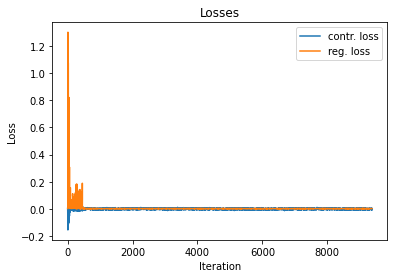

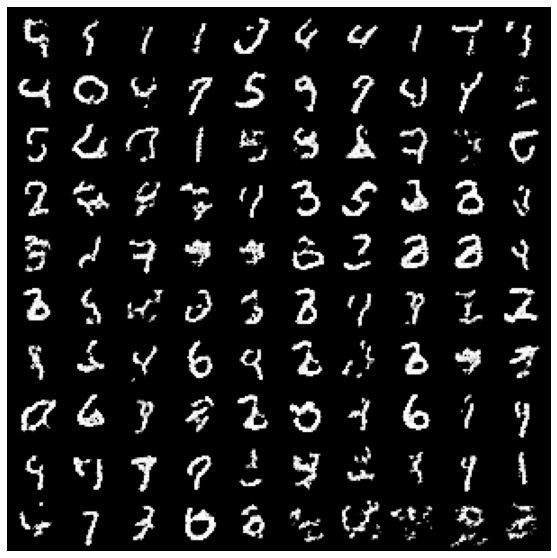

In [34]:
q1_results(q1) # 20 ep

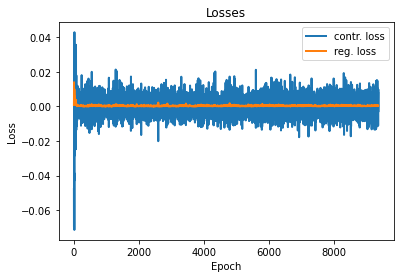

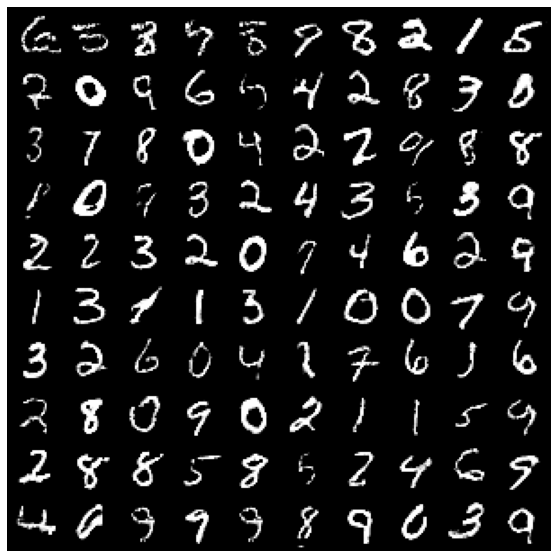

In [ ]:
q1_results(q1) # ref

# Question 2: EBM conditional generation

Here we will train EBM jointly with classifier to generate objects conditioned on class labels. ([original paper](https://arxiv.org/pdf/1912.03263.pdf)).

* **Theory**. Here we will work with joint distribution on x (data point) and y (label). We will parametrize probability of the pair as follows

```
p_θ(x, y) = exp(f_θ(x)[y]) / Z(θ)
```
Where `f(x)[y]` is an y-th output of the classifier model and `Z(θ)` is a normalization constant.

We will optimize log-likelihood of train pair:

```
log p(x, y) = log p(x) + log p(y|x)
```

Second term corresponds to normal classification loss and we will optimize it with cross entropy. We will optimize first tirm via contrastive divergence. The energy of can be from classifire output : `E(x)=-log ∑ exp(f_θ(x)[y])`.

* **Architecture.** We will work with smile dataset and you can use architecture from practice.

* **Hyperparameters**
    * Max buffer size - 8192
    * MCMC step size - 0.1
    * MCMC # step - 500 (during final sampling you can increase it)
    * MCMC noise - N(0, 0.005)
    * Noise to data - None
    * l2 reg weight - 0.1
    * batch_size - 128
    * use Adam with lr=1e-3 and betas=(0, 0.999)
    * you can use exponential scheduler
    * 100 epochs should be enough (~10 minutes on cpu)



**You will provide the following deliverables**


1.   Over the course of training, record loss per batch.
3. 300 samples from your trained EBM. First 100 samples should be generated for label 0, next 100 for label 1, and last 100 for label 2

In [17]:
class Buffer():
    def __init__(self, max_size=8192):
        self.max_size = max_size
        self.buffer = torch.empty(0, 2).to(device)

    def buffer_size(self,):
        return self.buffer.shape[0]

    def free_space(self,):
        return self.max_size - self.buffer.shape[0]

    def sample(self, n):
        ids = torch.randint(0, self.buffer_size(), (n,))
        return self.buffer[ids]

    def update(self, x):
        if self.free_space() == 0:
            self.buffer = self.buffer[-(self.max_size - x.shape[0]):]
            self.buffer = torch.cat([self.buffer, x], dim=0)
        elif x.shape[0] < self.free_space():
            self.buffer = torch.cat([self.buffer, x], dim=0)
        else:
            to_free = x.shape[0] - self.free_space()
            self.buffer = self.buffer[-(self.buffer_size() - to_free):]
            self.buffer = torch.cat([self.buffer, x], dim=0)

In [36]:
from torch.autograd import Variable

class Net(nn.Module):
    def __init__(self, hd=128, out_dim=3):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(2, hd), 
                                   nn.LeakyReLU(0.2),
                                   nn.Linear(hd, hd), 
                                   nn.LeakyReLU(0.2),
                                   nn.Linear(hd, hd),
                                   nn.LeakyReLU(0.2),
                                   nn.Linear(hd, out_dim))
    def forward(self, x):
        x = self.model(x)
        return x

class ConditionalEBM(nn.Module):
    def __init__(self, max_buffer_size=8192, mcmc_step_size=0.1, 
                 mcmc_steps=500, data_noise=0, mcmc_noise=0.005,
                 l2_reg_weight=0.1):
        super().__init__()

        self.buffer = Buffer(max_buffer_size)
        self.mcmc_step_size = mcmc_step_size
        self.mcmc_steps = mcmc_steps
        self.data_noise = data_noise
        self.mcmc_noise = mcmc_noise
        self.l2_reg_weight = l2_reg_weight
        self.f = Net()
        
    
    def loss(self, real, labels, fake, noise=0):
        noise = torch.randn(real.shape) * noise # ** 0.5
        real = real + noise
        real = real.to(device)

        logits_real = self.f(real)
        logits_fake = self.f(fake)

        e_real = -torch.logsumexp(logits_real, dim=1)
        e_fake = -torch.logsumexp(logits_fake, dim=1)

        l2_reg = e_fake ** 2 + e_real ** 2
        t1 = -(e_fake.mean() - e_real.mean()) + self.l2_reg_weight * l2_reg.mean()
        t2 = F.cross_entropy(logits_real, labels.long())

        loss = t1 + t2
        return loss


    def fit(self, train_dataset, lr=1e-3, num_epochs=100, bs=128, betas=(0, 0.999)):
        trainloader = data.DataLoader(train_dataset,
                                      batch_size=bs, 
                                      shuffle=True)

        optim = opt.Adam(self.f.parameters(), lr=lr, betas=betas)
        sch = opt.lr_scheduler.ExponentialLR(optim, gamma=0.1)
        train_loss = []
        
        for epoch in tqdm(range(num_epochs)):
            t_losses = []
            for i, (r_batch, r_labels) in enumerate(tqdm(trainloader)):
                r_batch = r_batch.float().to(device)
                r_labels = r_labels.to(device)

                bs = r_batch.shape[0]
                f_batch = self.sample(n_samples=bs)

                loss = self.loss(r_batch, r_labels, f_batch, self.data_noise)
                optim.zero_grad()
                loss.backward()
                optim.step()

                train_loss.append(loss.item())
                t_losses.append(loss.item())


            print(f'Epoch {epoch + 1}: loss= {np.mean(t_losses):.5f}')
            sch.step()

        return np.array(train_loss)


    def energy_freeze(self,):
        for p in self.f.parameters():
            p.requires_grad = False

    def energy_unfreeze(self,):
        for p in self.f.parameters():
            p.requires_grad = True

    def sample(self, n_samples=100):
        self.energy_freeze()
        self.f.eval()

        if self.buffer.buffer_size() == 0:
            # x1 = (torch.rand(n_samples, 1) - 0.5) * 5.4
            # x2 = torch.rand(n_samples, 1) * 5.5 - 2
            # x = torch.cat([x1, x2], dim=1)
            x = (torch.rand(n_samples, 2) - 0.5) * 2
            x = x.to(device)
        else:
            buffer_start_num = int(0.95 * n_samples)
            random_start_num = n_samples - buffer_start_num
            x_buf = self.buffer.sample(buffer_start_num)

            # x1 = (torch.rand(random_start_num, 1) - 0.5) * 5.4
            # x2 = torch.rand(random_start_num, 1) * 5.5 - 2
            # x_rand = torch.cat([x1, x2], dim=1)
            x_rand = (torch.rand(random_start_num, 2) - 0.5) * 2
            x_rand = x_rand.to(device)
            x = torch.cat([x_buf, x_rand], dim=0)
        x = Variable(x)
        x.requires_grad = True
        
        for _ in range(self.mcmc_steps):
            e = -torch.logsumexp(self.f(x), dim=1)
            score_fun = -torch.autograd.grad(outputs=e.sum(), inputs=x)[0] 
            score_fun = torch.clamp(score_fun, min=-0.03, max=0.03)
            z = torch.randn(x.shape) * self.mcmc_noise # ** 0.5
            z = z.to(device)
            x = x + self.mcmc_step_size * score_fun + (2 * self.mcmc_step_size) ** 0.5 * z
            x = torch.clamp(x, min=-3, max=3)

        self.buffer.update(x)
        self.energy_unfreeze()
        self.f.train()
        return x


    def conditional_sample(self, n_samples=100, label=0):
        self.energy_freeze()
        self.f.eval()

        if self.buffer.buffer_size() == 0:
            # x1 = (torch.rand(n_samples, 1) - 0.5) * 5.4
            # x2 = torch.rand(n_samples, 1) * 5.5 - 2
            # x = torch.cat([x1, x2], dim=1)
            x = (torch.rand(n_samples, 2) - 0.5) * 2
            x = x.to(device)
        else:
            buffer_start_num = int(0.95 * n_samples)
            random_start_num = n_samples - buffer_start_num
            x_buf = self.buffer.sample(buffer_start_num)

            # x1 = (torch.rand(random_start_num, 1) - 0.5) * 5.4
            # x2 = torch.rand(random_start_num, 1) * 5.5 - 2
            # x_rand = torch.cat([x1, x2], dim=1)
            x_rand = (torch.rand(random_start_num, 2) - 0.5) * 2
            x_rand = x_rand.to(device)
            x = torch.cat([x_buf, x_rand], dim=0)
        x = Variable(x)
        x.requires_grad = True
        
        for _ in range(self.mcmc_steps):
            e = -self.f(x)[:, label] # torch.logsumexp(, dim=1)
            score_fun = -torch.autograd.grad(outputs=e.sum(), inputs=x)[0] 
            score_fun = torch.clamp(score_fun, min=-0.03, max=0.03)
            z = torch.randn(x.shape) * self.mcmc_noise # ** 0.5
            z = z.to(device)
            x = x + self.mcmc_step_size * score_fun + (2 * self.mcmc_step_size) ** 0.5 * z
            x = torch.clamp(x, min=-3, max=3)

        # self.buffer.update(x)
        self.energy_unfreeze()
        self.f.train()
        return x

In [37]:
from torch.utils.data import Dataset

class PointsDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [40]:
def q2(train_data, train_labels):
    """
    train_data: An (n_train, 2) np.array of binary points
    train_labels: An (n_train, ) np.array labels (3 classes)
    Returns
    - a (# of training iterations, ) numpy array full of losses on each iteration
    - a (300, 2) numpy array of 300 samples from ebm model (0-99 with label 0; 100-199 with label 1; 200-300 with label 2)
    """

    train_data = torch.Tensor(train_data)
    train_labels = torch.Tensor(train_labels)
    train_dataset = PointsDataset(train_data, train_labels)

    model = ConditionalEBM()
    model.to(device)
    t_loss = model.fit(train_dataset, num_epochs=50)

    samples0 = model.conditional_sample(100, 0).detach().cpu().numpy()
    samples1 = model.conditional_sample(100, 1).detach().cpu().numpy()
    samples2 = model.conditional_sample(100, 2).detach().cpu().numpy()
    samples = np.stack([samples0, samples1, samples2], axis=0)

    return t_loss, samples

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1: loss= 0.80856


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 2: loss= 0.30961


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 3: loss= 0.26589


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 4: loss= 0.26572


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 5: loss= 0.25667


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 6: loss= 0.25767


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 7: loss= 0.24015


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 8: loss= 0.25795


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 9: loss= 0.25239


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 10: loss= 0.25382


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 11: loss= 0.23945


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 12: loss= 0.24606


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 13: loss= 0.24555


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 14: loss= 0.23816


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 15: loss= 0.22113


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 16: loss= 0.24240


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 17: loss= 0.22456


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 18: loss= 0.22698


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 19: loss= 0.21831


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 20: loss= 0.22360


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 21: loss= 0.22189


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 22: loss= 0.21884


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 23: loss= 0.21578


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 24: loss= 0.21636


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 25: loss= 0.21546


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 26: loss= 0.21047


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 27: loss= 0.21362


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 28: loss= 0.21877


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 29: loss= 0.20931


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 30: loss= 0.21295


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 31: loss= 0.21930


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 32: loss= 0.21165


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 33: loss= 0.21802


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 34: loss= 0.21961


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 35: loss= 0.23105


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 36: loss= 0.20714


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 37: loss= 0.22439


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 38: loss= 0.21270


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 39: loss= 0.21680


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 40: loss= 0.20863


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 41: loss= 0.20884


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 42: loss= 0.21906


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 43: loss= 0.20809


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 44: loss= 0.21002


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 45: loss= 0.20846


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 46: loss= 0.21520


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 47: loss= 0.21628


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 48: loss= 0.21618


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 49: loss= 0.22128


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 50: loss= 0.20997


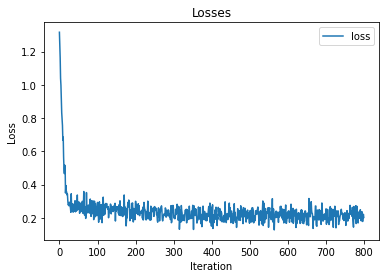

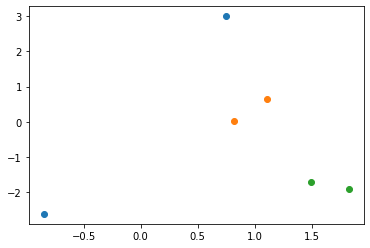

In [ ]:
q2_results(q2)  # 50 ep

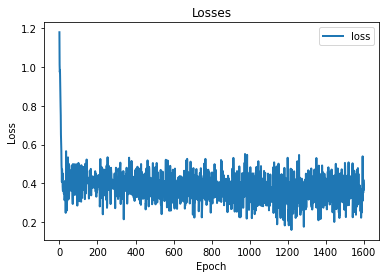

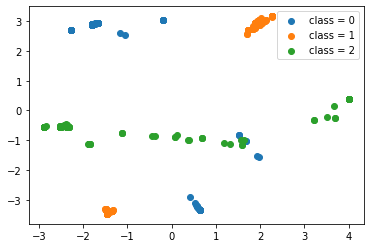

In [ ]:
q2_results(q2) # ref

# Bonus : Conditional generation with EBM and classifier.

Here you need to generate points conditioned on class on smile dataset with independently trained ebm and classifier. For generation use MCMC with

```
log p(x|y) ~ log p(x) + log p(y|x)
```

Where first term is `-E(x)` and second is obtained via backprop from trained classifier.

In [ ]:
def b(train_data, train_labels):
    """
    train_data: An (n_train, 2) np.array of binary points
    train_labels: An (n_train, ) np.array labels (3 classes)
    Returns
    - a (# of training iterations, ) numpy array full of losses of classfier on each iteration
    - a (# of training iterations, ) numpy array full of losses of ebm on each iteration
    - a (300, 2) numpy array of 300 samples from ebm model (0-99 with label 0; 100-199 with label 1; 200-300 with label 2)
    """

In [ ]:
b_results(b)